In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from pprint import pprint
import random
import os

Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
model_type = 'resnet'
input_shape = (32, 32, 3)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models_improve_occlude')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
model_name = 'cifar10occlude_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


In [3]:
Input = keras.layers.Input
Conv2D = keras.layers.Conv2D
Activation = keras.layers.Activation
BatchNormalization = keras.layers.BatchNormalization
AveragePooling2D = keras.layers.AveragePooling2D
Flatten = keras.layers.Flatten
Dropout = keras.layers.Dropout
Dense = keras.layers.Dense

def block_bac(inputs, filters, activation='relu', kernel_size=1, strides=1, padding='same'):
    b = BatchNormalization()(inputs)
    a = Activation(activation)(b)
    c = Conv2D(filters, kernel_size, strides=strides, padding=padding)(a)
    return c

def block_res(inputs, small, large, firstlayer=False, firststride=2, returnshortcut=False):
    if firstlayer:
        s = Conv2D(filters=large, kernel_size=1, padding='same', strides=firststride)(inputs)
    else:
        s = inputs
    c = block_bac(inputs, filters=small, kernel_size=1)
    c = block_bac(c, filters=small, kernel_size=3)
    if firstlayer:
        c = block_bac(c, filters=large, kernel_size=1, strides=firststride)
    else:
        c = block_bac(c, filters=large, kernel_size=1, strides=1)
    if returnshortcut:
        return keras.layers.add([c, s]), s
    else:
        return keras.layers.add([c, s])
    

# Input block
i = Input(shape=input_shape)
c = Conv2D(filters=16, kernel_size=3, padding='same')(i)
b = BatchNormalization()(c)
a = Activation('relu')(b)

# m2
m2r = block_res(a, 16, 64, firstlayer=True, firststride=1)
m2r = block_res(m2r, 16, 64)
m2r = block_res(m2r, 16, 64)

m2r = block_res(m2r, 64, 128, firstlayer=True)
m2r = block_res(m2r, 64, 128)
m2r = block_res(m2r, 64, 128)

m2b = BatchNormalization()(m2r)

m2a = Activation('relu')(m2b)
m2av = AveragePooling2D(16)(m2a)
m2f = Flatten()(m2av)

m2d = Dense(2)(m2f)
m2ac = Activation('softmax')(m2d)

# m1
r = block_res(a, 16, 64, firstlayer=True, firststride=1)
r = block_res(r, 16, 64)
r = block_res(r, 16, 64)

r = block_res(r, 64, 128, firstlayer=True)
r = block_res(r, 64, 128)
r = block_res(r, 64, 128)

r = keras.layers.concatenate([r, m2r], axis=-1)
# sd2d = keras.layers.SpatialDropout2D(0.3, data_format='channels_last')(r)

r = block_res(r, 128, 256, firstlayer=True)
r = block_res(r, 128, 256)
r = block_res(r, 128, 256)

b = BatchNormalization()(r)

a = Activation('relu')(b)
av = AveragePooling2D(8)(a)
f = Flatten()(av)

d = Dense(num_classes)(f)
ac = Activation('softmax')(d)

model = keras.Model(inputs=i, outputs=ac)

model2 = keras.Model(inputs=i, outputs=m2ac)

model


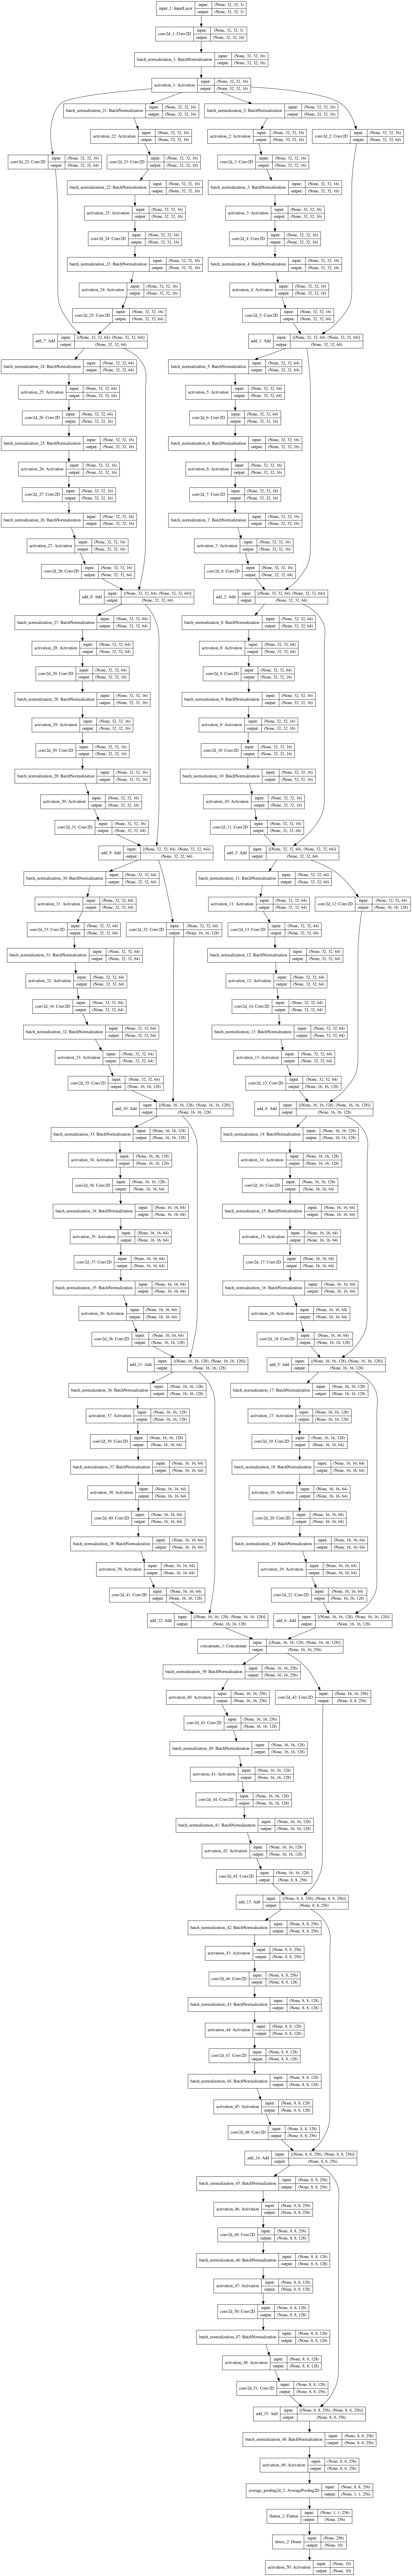

In [4]:
print('model')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

model2


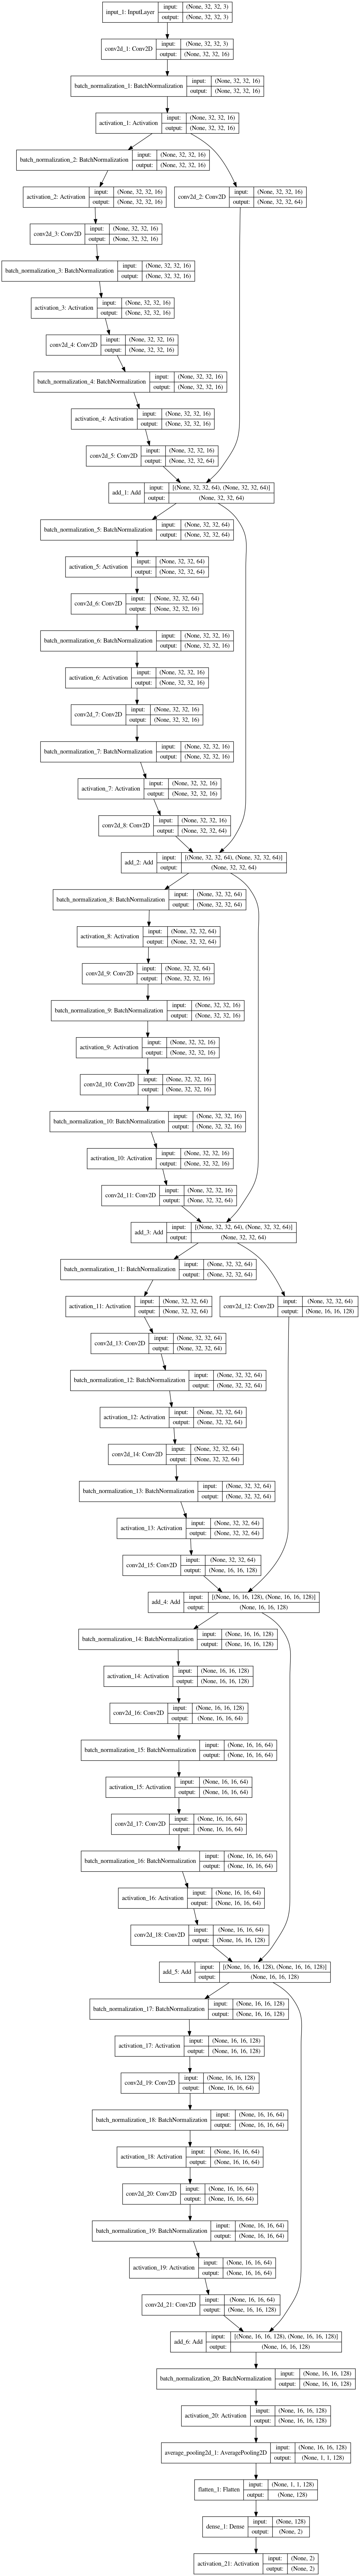

In [5]:
print('model2')
keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True)

In [6]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

lr_reducer = keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                               cooldown=0,
                                               patience=5,
                                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]
callbacks = [lr_reducer, lr_scheduler]


def recompile(thismodel, trainable='all', epochs=0):
    # All trainable
    if trainable == 'all':
        for layer in thismodel.layers:
            layer.trainable = True
    
    # All dis-trainable
    if trainable == 'none':
        for layer in thismodel.layers:
            layer.trainable = False
    
    # Trainable trainable
    if type(trainable) == list:
        for layer in thismodel.layers:
            layer.trainable = False
            if layer.name in trainable:
                layer.trainable = True
        
    thismodel.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(epochs)),
                      metrics=['accuracy'])

recompile(model, 'all')
recompile(model2, 'all')


Learning rate:  0.001
Learning rate:  0.001


In [7]:
def occlude(img):
    x, y = np.random.randint(5, 20, 2)
    w, h = np.random.randint(10, 20, 2)
    img[x:x+w, y:y+h, :] = np.random.randn(3)
    return img

def occlude_all(X):
    for j in range(len(X)):
        X[j] = occlude(X[j])
    return X

(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = keras.datasets.cifar10.load_data()
print(X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape)

# Normalize data.
X_train_raw = X_train_raw.astype('float32') / 255
X_test_raw = X_test_raw.astype('float32') / 255

# Subtract pixel mean is enabled
X_train_mean = np.mean(X_train_raw, axis=0)
X_train_raw -= X_train_mean
X_test_raw -= X_train_mean

X_train_occ = occlude_all(X_train_raw.copy())
X_test_occ = occlude_all(X_test_raw.copy())

X_train_mix = np.concatenate([X_train_raw, X_train_occ])
y_train_mix = np.concatenate([y_train_raw * 0, y_train_raw * 0 + 1])

X_test_mix = np.concatenate([X_test_raw, X_test_occ])
y_test_mix = np.concatenate([y_test_raw * 0, y_test_raw * 0 + 1])

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [8]:
# Convert class vectors to binary class matrices.
y_train_raw = keras.utils.np_utils.to_categorical(y_train_raw, num_classes)
y_test_raw = keras.utils.np_utils.to_categorical(y_test_raw, num_classes)

y_train_mix = keras.utils.np_utils.to_categorical(y_train_mix, 2)
y_test_mix = keras.utils.np_utils.to_categorical(y_test_mix, 2)

datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

datagen.fit(X_train_mix)

In [9]:
r = np.random.permutation(range(len(X_train_mix)))
r = r[:10000]
model2.fit_generator(datagen.flow(X_train_mix[r], y_train_mix[r], batch_size=batch_size),
                     epochs=2,
                     validation_data=(X_test_mix, y_test_mix),
                     workers=32,
                     callbacks=callbacks)

model.fit_generator(datagen.flow(X_train_occ, y_train_raw, batch_size=batch_size),
                    epochs=200,
                    validation_data=(X_test_occ, y_test_raw),
                    workers=32,
                    callbacks=callbacks)

Epoch 1/2
Learning rate:  0.001
313/313 [==============================] - 37s 118ms/step - loss: 0.1761 - accuracy: 0.9424 - val_loss: 0.2088 - val_accuracy: 0.9283
Epoch 2/2
Learning rate:  0.001
313/313 [==============================] - 28s 89ms/step - loss: 0.1326 - accuracy: 0.9566 - val_loss: 0.1037 - val_accuracy: 0.9763
Epoch 1/200
Learning rate:  0.001
1563/1563 [==============================] - 220s 141ms/step - loss: 1.6702 - accuracy: 0.3829 - val_loss: 1.4989 - val_accuracy: 0.4553
Epoch 2/200
Learning rate:  0.001
1563/1563 [==============================] - 195s 125ms/step - loss: 1.3353 - accuracy: 0.5193 - val_loss: 1.5151 - val_accuracy: 0.4990
Epoch 3/200
Learning rate:  0.001
1563/1563 [==============================] - 197s 126ms/step - loss: 1.1768 - accuracy: 0.5790 - val_loss: 1.1437 - val_accuracy: 0.6011
Epoch 4/200
Learning rate:  0.001
1563/1563 [==============================] - 197s 126ms/step - loss: 1.0588 - accuracy: 0.6238 - val_loss: 1.1377 - val_ac

In [11]:
scores = model.evaluate(X_test_occ, y_test_raw, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 8s 805us/step
Test loss: 0.6962502078652382
Test accuracy: 0.8600000143051147


In [12]:
save_dir

'/home/zcc/Documents/cifar10_occlude/saved_models_improve_occlude'

In [13]:
model_name

'cifar10occlude_resnet_model.{epoch:03d}.h5'

In [33]:
model.save(os.path.join(save_dir, model_name.format(**{'epoch': 200})))